In [1]:
import os
try:
    os.chdir(base_dir) #if the start up file has already been run, this will change the dir back to base
except NameError:
    base_dir = None #if the start up file hasn't been run yet, this will allow us to run this cell without crashing

%run ./startup_file.ipynb #run startup file and install libraries if necessary

# LEVEL3_SATDATA

## Author: haley synan

##### *Last run on 2024-08-01*

**Adapted for Python based on KHyde's bin2ll IDL program**

#### Objectives:
* read l3b file and extract data / grid
* To get chla data:
  * [chlor_a = chlor_a_sum / chlor_a_weights](http://ocean.stanford.edu/research/seadas7.html)
* Convert bin numbers to lat/lon:
  * https://oceancolor.gsfc.nasa.gov/docs/ocssw/bin__csub_8c_source.html

#### Table of Contents
* [Level 3 Binned](#one)
  * [Load data](#three)
  * [Define variables](#four)
  * [Convert bin numbers to coordinates](#five)
  * [Subset data](#six)
  * [Visualize](#seven)
* [Level 3 Mapped](#two)
  * [Load data](#eight)
  * [Visualize](#nine)
* [Full grid](#ten)

#### History: <br>
>* *7/31/2024: created* <br>
>* *8/1/2024:*
>> * *updated code*
>> * *added basic plots*
>> * turned code into bin2ll function
>             

https://oceancolor.gsfc.nasa.gov/resources/docs/technical/ocean_level-3_binned_data_products.pdf

# Level 3 Binned <a class="anchor" id="one"></a>

#### Load data <a class="anchor" id="three"></a>

In [2]:
os.chdir(data_dir)
fname = 'PACE_OCI.20240717.L3b.DAY.CHL.V2_0.NRT.nc'
filepath = data_dir + '/' + fname

In [3]:
#check groups names 
import h5netcdf
with h5netcdf.File(fname) as file:
    groups = list(file)
groups

['level-3_binned_data', 'processing_control']

In [4]:
l3b = xr.open_dataset(fname, group= groups[0])

#### Define variables <a class="anchor" id="four"></a>

In [5]:
# Extract chla data
binnum = l3b.BinList.values['bin_num']
weight = l3b.BinList.values['weights']
sum = l3b.chlor_a.values['sum']
chla_data = sum/weight

In [6]:
# Define vars for bin2ll 
inbin = l3b.BinList.values['bin_num'] #total number of bins 
nrows = len(l3b.BinIndex) #total number of rows for binning 
i = np.arange(nrows)
latbin=(i + 0.5) * (180.000 / nrows) - 90.0 #center latitude of each row
numbin = []
for x in range(len(latbin)):
    nb = math.cos(latbin[x] *math.pi/180.0) * (2.0*nrows) +0.5
    nbb = math.floor(nb)
    numbin.append(nbb)
numbin = array(numbin) #no. of bin in each row

basebin = np.arange(nrows) #1st bin of each row
basebin[0] = 1 

for i in range(1,nrows-1):
    basebin[i]= basebin[i-1] + numbin[i-1]

#totbins = basebin[nrows-1] + numbin[nrows-1] - 1 #total bin numbers
#basebin = [basebin, totbins+1]

#### Convert bin numbers to coordinates  <a class="anchor" id="five"></a>

In [7]:
n_inbin = len(inbin)
outlat= []
outlon=[]
for x in range(len(inbin)):
    bin = inbin[x]
    lat = bin2ll(inbin, basebin, latbin, numbin)[0]
    lon = bin2ll(inbin, basebin, latbin, numbin)[1]
    outlat.append(lat)
    outlon.append(lon)

#OLD VERSION - NOT IN FUNCTION
#oldrow = 1
#for x in range(1,len(inbin)+1):
#for x in range(len(inbin)):
#    bin = inbin[x]
#    if bin > basebin[oldrow-1] and bin < basebin[oldrow-1]:
#        row = oldrow
#    else: 
#        rlow = 1
#        rhi = nrows
#        row = -1
#        while (row != rlow):
#            rmid = (rlow+rhi-1)/2
#            rmid = int(rmid)
#            if (basebin[rmid] > bin):
#                rhi = rmid
#            else:
#                rlow = rmid+1
#            if rlow == rhi:
#               row = rlow
#                oldrow = row
#    lat = latbin[row-1]
#    lon = 360.00 *(bin- basebin[row-1]+0.5) / numbin[row-1]
#    lon = lon -180
#    outlat.append(lat)
#    outlon.append(lon)

#### Subset data <a class="anchor" id="six"></a>

In [8]:
outlat = array(outlat)
outlon = array(outlon)
idx_lat = np.where(outlat>34)
outlat = outlat[idx_lat[0]]
outlon = outlon[idx_lat[0]]
chla_data= chla_data[idx_lat[0]]

idx_lat = np.where(outlat<47)
outlat = outlat[idx_lat[0]]
outlon = outlon[idx_lat[0]]
chla_data= chla_data[idx_lat[0]]


idx_lon= np.where(outlon > -77 )
outlat = outlat[idx_lon[0]]
outlon = outlon[idx_lon[0]]
chla_data= chla_data[idx_lon[0]]

idx_lon= np.where(outlon < -63)
outlat = outlat[idx_lon[0]]
outlon = outlon[idx_lon[0]]
chla_data= chla_data[idx_lon[0]]

#### Visualize <a class="anchor" id="seven"></a>

Text(0.1, 0.66, 'Date: 2024-07-17')

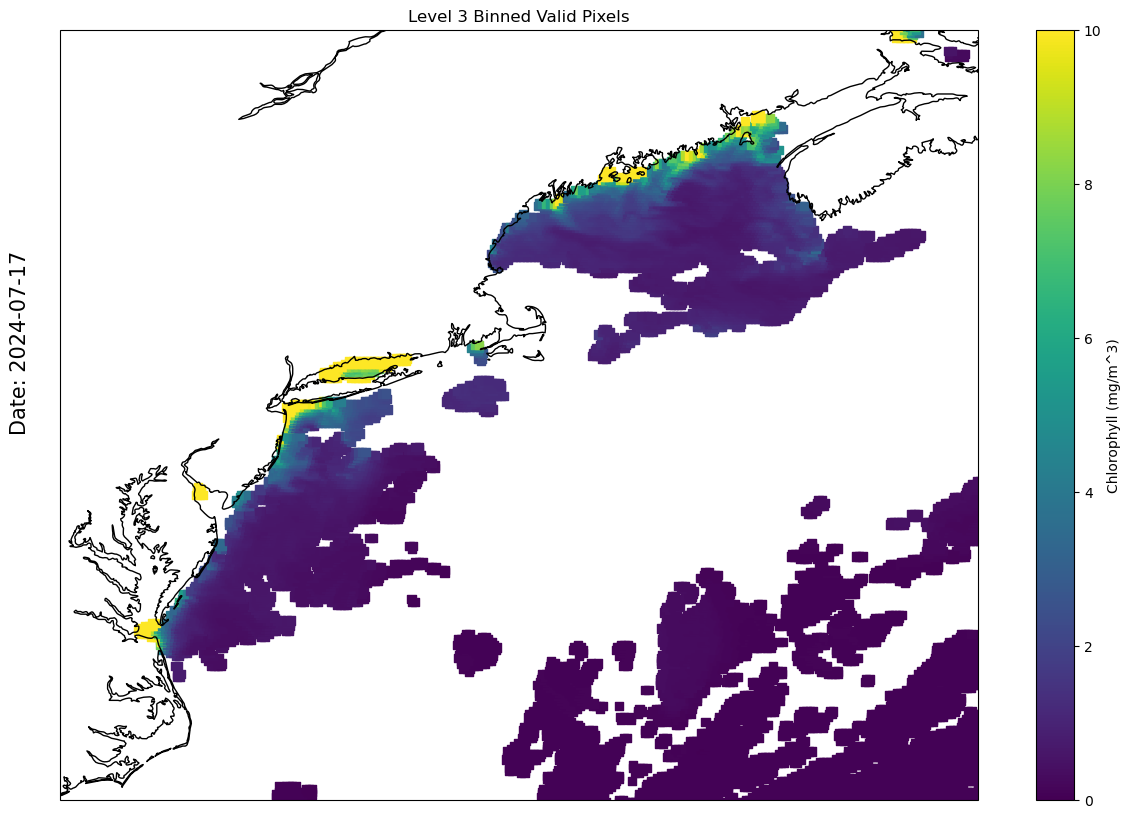

In [9]:
#import cmocean
fig = plt.figure(figsize=(15, 10)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
im = plt.scatter(outlon,outlat,c=chla_data, marker='s', vmin = 0, vmax=10)#cmap=cmocean.cm.algae_r)
plt.xlim([-77.5, -63.2])
plt.ylim([34.4, 46.4])
ax.coastlines()
plt.colorbar(im, label='Chlorophyll (mg/m^3)')
plt.title('Level 3 Binned Valid Pixels')
plt.suptitle('Date:'+ ' ' +xr.open_dataset(fname).attrs['time_coverage_start'].split('T')[0], y = 0.66, x=0.1, fontsize = 15, rotation = 90, ha='left')

# Level 3 Mapped <a class="anchor" id="two"></a>

#### Load data  <a class="anchor" id="eight"></a>

In [10]:
l3m = xr.open_dataset('PACE_OCI.20240717.L3m.DAY.CHL.V2_0.chlor_a.0p1deg.NRT.nc')

#### Visualize data <a class="anchor" id="nine"></a>

Text(0.18, 0.5, 'Date: 2024-07-17')

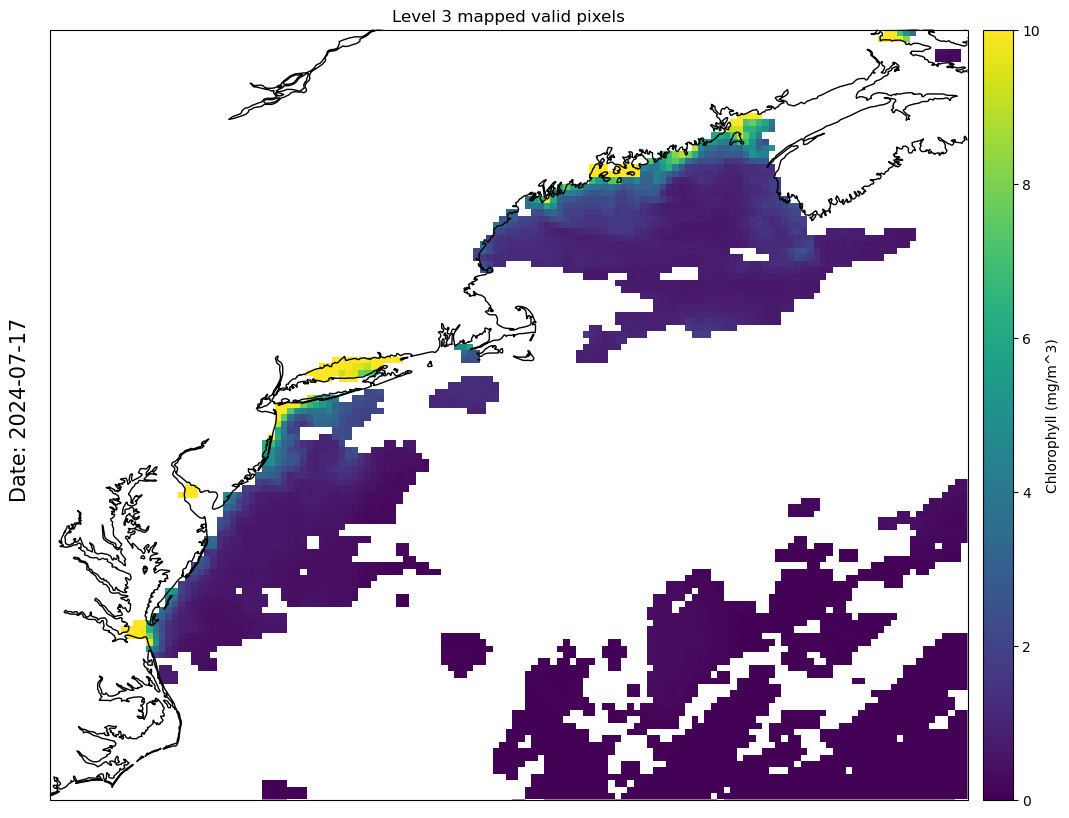

In [11]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=cartopy.crs.PlateCarree()) 
im = l3m.chlor_a.plot(vmin = 0, vmax = 10, add_colorbar=False, xlim =[-77.5, -63.2] , ylim = [34.4, 46.4])
#plt.colorbar(im, label='chla')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax ,label='Chlorophyll (mg/m^3)') # Similar to fig.colorbar(im, cax = cax)
ax.coastlines()
ax.set_title('Level 3 mapped valid pixels')
#plt.title('Level 3 mapped valid pixels', loc='left')
plt.suptitle('Date:'+ ' ' +xr.open_dataset(fname).attrs['time_coverage_start'].split('T')[0], y = 0.5, x=0.18, fontsize = 15, rotation = 90, ha='left', va='center')

### FULL grid  <a class="anchor" id="ten"></a>
Not just valid pixels 

In [17]:
#get size of input array 
lat_map = read_csv('L3B4_latitude_subset.csv', header=None)
lon_map = read_csv('L3B4_longitude_subset.csv', header= None)

In [ ]:
#check for difference 